We begin by importing three classes made from scratch: LogisticRegression, KFoldSplitSet, and NestedCV. In addition to these, numpy, pandas, and itertools is also imported.



In [1]:
from LogisticRegression import LogisticRegression
from SplitSet import SplitSet
from NestedCrossValidation import NestedCV
import pandas as pd
import numpy as np
import itertools

First, the mushroom dataset must be processed to appropriately train the logistic classifier. A header row is added and a class vector is constructed from the last column of the dataset.

In [2]:
# Load the data
mushroom_set = pd.read_csv('Mushroom.csv')
mushroom_headers = ['Poisonous', 'Cap-shape', 'Cap-surface', 'Cap-color',
                    'Bruises', 'Odor', 'Gill-attachment',  'Gill-spacing',
                    'Gill-size', 'Gill-color', 'Stalk-color-below-ring', 'Class']
mushroom_set.columns = mushroom_headers

# Get the labels from last column
X = mushroom_set.iloc[:, :-1]
Y = mushroom_set.iloc[:, -1]

An automated process was designed to choose candidate models that had the highest accuracy based on a nested cross validation algorithm. A hyperparameter grid was constructed to identify the best learning rate, regularization, and norm penalty.

In [18]:
hyperparameters = {
    'lr': [0.0001, 0.001, 0.03],
    'reg': ['l1', 'l2'],
    'norm_penalty': [0, 0.3, 0.5, 0.8]
}
hyper_perms = list(itertools.product(*hyperparameters.values()))

# Remove l2 with 0 norm penalty since it's the same as l1 with 0 norm penalty (no regularization)
hyper_perms = [perm for perm in hyper_perms if [perm[1], perm[2]] != ['l2', 0]]

A nested cross validation is performed with 10 outer folds to procure candidate models that perform the best in the grid search validation process.

In [19]:
# Perform k-fold cross validation on each hyperparameter permutation to find the best one
nested_cv = NestedCV(outer_folds=10)

# Keep track of the top 5 best hyperparameter permutations
best_accuracy = 0
best_perm = None
top_5 = []

for perm in hyper_perms:
    model = LogisticRegression(perm[0], perm[1], perm[2], early_stopping=True)
    accuracy = nested_cv.k_fold_cross_validation(model, X, Y)
    
    # Update the top 5 best hyperparameter permutations
    if len(top_5) < 5:
        top_5.append((accuracy, perm))
    elif accuracy > top_5[0][0]:
        top_5[0] = (accuracy, perm)
        top_5.sort(key=lambda x: x[0])

    if accuracy > best_accuracy:
        best_accuracy = accuracy

# Print the top 5 best hyperparameter permutations
print("Top 5 best hyperparameter permutations:")
top_5.sort(key=lambda x: x[0])
for i, perm in enumerate(top_5):
    print("{}. Accuracy: {:.2f}%, Hyperparameters: {}".format(i+1, perm[0]*100, perm[1]))

# Get the best model
best_model = LogisticRegression(top_5[-1][1][0], top_5[-1][1][1], top_5[-1][1][2], early_stopping=True)

Top 5 best hyperparameter permutations:
1. Accuracy: 73.83%, Hyperparameters: (0.001, 'l1', 0.8)
2. Accuracy: 73.95%, Hyperparameters: (0.001, 'l2', 0.5)
3. Accuracy: 74.01%, Hyperparameters: (0.001, 'l1', 0)
4. Accuracy: 74.26%, Hyperparameters: (0.001, 'l2', 0.3)
5. Accuracy: 74.26%, Hyperparameters: (0.001, 'l1', 0.3)


The best performing models each have a learning rate of 0.001. In the case of this mushroom dataset, it does not appear as though regularization increases the performance of the model very much as no regularization, L1, and L2 all can achieve a similar accuracy.

We can now do some analysis with the best model selected. First let's see how it used regularization to place less importance on some features.

In [20]:
# Generate splits
splits = SplitSet()
X_train, X_test, Y_train, Y_test = splits.split(X, Y, test_size=0.2)
x_train, x_val, y_train, y_val = splits.split(X_train, Y_train, test_size=0.2)

# Train the best model
best_model.fit(x_train, y_train, x_val, y_val)

# Check the weights per feature
headers = ['Intercept', 'Poisonous', 'Cap-shape', 'Cap-surface', 'Cap-color',
                    'Bruises', 'Odor', 'Gill-attachment',  'Gill-spacing',
                    'Gill-size', 'Gill-color', 'Stalk-color-below-ring']
weights = best_model.w
data = {'Feature': headers, 'Weight': weights}
weights_df = pd.DataFrame(data)
print(weights_df)

                   Feature    Weight
0                Intercept -0.277605
1                Poisonous  0.678633
2                Cap-shape -2.687853
3              Cap-surface  0.542023
4                Cap-color  0.094531
5                  Bruises -0.649781
6                     Odor  0.317348
7          Gill-attachment -1.785765
8             Gill-spacing -1.133813
9                Gill-size  0.142082
10              Gill-color  1.873331
11  Stalk-color-below-ring  4.026373


It appears as though some features are more important than others. For example, the weights on "Stalk-color-below-ring", "Cap-shape", "Gill-attachment", and "Gill-color" seem to be of a higher magnitude than the others. "Gill-size", "Cap-color", and "Odor", seem to often be less important than the other features. We can see what happens if we remove these features entirely. 

In [21]:
# Test the best model with "Gill-size", "Cap-color", and "Odor" removed from the dataset
X_reduced = X.drop(columns=['Gill-size', 'Cap-color', 'Odor'])
accuracy_reduced = nested_cv.k_fold_cross_validation(best_model, X_reduced, Y)
print("Accuracy with reduced features: ", accuracy_reduced)
print("Difference in accuracy: ", best_accuracy - accuracy_reduced)

Accuracy with reduced features:  0.7401234567901235
Difference in accuracy:  0.0024691358024691024


Early stopping is enforced by observing the performance of the model on a validation set during training. If the accuracy of prediction does not increase by more than 0.001 over 250 consecutive iterations, the model stops training. Let's see how this affects performance.

Test set accuracy with no stopping (1000 iterations): 0.7716049382716049
Time elapsed: 0.4700050354003906


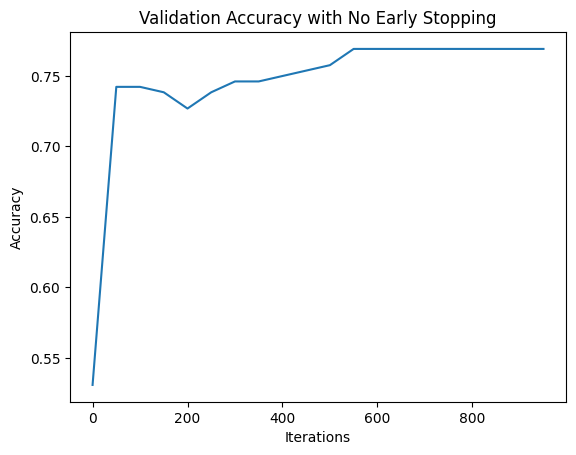

Test set accuracy with stopping after 300 iterations: 0.7561728395061729
Time elapsed: 0.13766694068908691


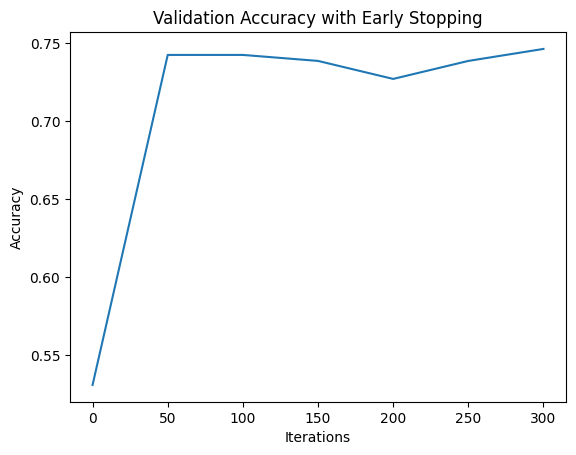

In [22]:
import matplotlib.pyplot as plt
import time

# Evaluate the best model with no early stopping
timer = time.time()
best_model.early_stopping = False
iterations, accuracies = best_model.fit(x_train, y_train, x_val, y_val)
Y_pred = best_model.predict(X_test)
accuracy = np.mean(Y_pred == Y_test)
print("Test set accuracy with no stopping (1000 iterations):", accuracy)
print("Time elapsed:", time.time() - timer)

# Make a plot of the accuracy vs iterations
plt.plot(iterations, accuracies)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy with No Early Stopping")
plt.show()

# Evaluate model with early stopping
timer = time.time()
best_model.early_stopping = True
iterations, accuracies = best_model.fit(x_train, y_train, x_val, y_val)
Y_pred = best_model.predict(X_test)
accuracy = np.mean(Y_pred == Y_test)
print(f"Test set accuracy with stopping after {iterations[-1]} iterations:", accuracy)
print("Time elapsed:", time.time() - timer)

# Make a plot of the accuracy vs iterations
plt.plot(iterations, accuracies)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy with Early Stopping")
plt.show()

Finally, we can compare the best model found against some benchmarks.

In [23]:
# Random classifier that predicts 50/50
Y_pred_random = np.random.randint(0, 2, len(Y_test))
accuracy = np.mean(Y_pred_random == Y_test)
print("Random classifier accuracy:", accuracy)

# Majority classifier that predicts all 1's
Y_pred_majority = np.ones(len(Y_test))
accuracy = np.mean(Y_pred_majority == Y_test)
print("Majority classifier accuracy:", accuracy)

# Minority classifier that predicts all 0's
Y_pred_minority = np.zeros(len(Y_test))
accuracy = np.mean(Y_pred_minority == Y_test)
print("Minority classifier accuracy:", accuracy)

# Print the models found by nested cross validation
print("\nModels found by nested cross validation:")
for i, model in enumerate(top_5):
    print("{}. Accuracy: {:.2f}%, Hyperparameters: {}".format(i+1, model[0]*100, model[1]))

Random classifier accuracy: 0.42592592592592593
Majority classifier accuracy: 0.5030864197530864
Minority classifier accuracy: 0.49691358024691357

Models found by nested cross validation:
1. Accuracy: 73.83%, Hyperparameters: (0.001, 'l1', 0.8)
2. Accuracy: 73.95%, Hyperparameters: (0.001, 'l2', 0.5)
3. Accuracy: 74.01%, Hyperparameters: (0.001, 'l1', 0)
4. Accuracy: 74.26%, Hyperparameters: (0.001, 'l2', 0.3)
5. Accuracy: 74.26%, Hyperparameters: (0.001, 'l1', 0.3)
